## Load the data in pickle file 

In [1]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [2]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


In [3]:
len(model_names)

72

### Load the real observations

In [4]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

# Preprocessing of the data: $(x_{i,t,m}^{p})_{i=1,\ldots,I, t=1,\ldots,T,m=1,\ldots,M, p=1,\ldots,d}$
## $i$: ensemble member (run) index
## $t$: time index
## $m$: model index
## $p$: grid cell index

#### Keep the model with at least 3 ensemble memebers and downscale the data from latitude 144 -> 36 with local averaging (to match with ensemble methods

In [5]:
import skimage

# first filter out the models that contain less than 5 ensemble members 
dic_reduced_ssp585 = {}

count_m = 0

for idx_m, m in enumerate(list(dic_ssp585.keys())):
    # print(len(dic_ssp585[m].keys()))
    if (len(dic_ssp585[m].keys()) > 4) and (count_m < 20):
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]
        count_m +=1

In [6]:
len(dic_reduced_ssp585.keys())

18

# Store Nan indices by taking maximum of nan coverage among the anomalies 

In [7]:
nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    
        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

### 1) Compute anomalies: $\displaystyle \overline{x}_{i,t,m}^p = x_{i,t,m}^p - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \sum_{i=1}^I x_{i,t,m}^p$

In [8]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    y_tmp = np.zeros((len(dic_reduced_ssp585[m].keys()),time_period, lat_size*lon_size))
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp[idx_i,:,:] = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[idx_i,:,nan_idx] = float('nan')
           
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp[idx_i,:,:] - mean_ref_ensemble

/tmp/ipykernel_5299/2788081108.py:17: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
/tmp/ipykernel_5299/2788081108.py:19: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())


### 2) Compute the forced response: 
#### - Mean over space: $\displaystyle y_{i,t,m} = \frac{1}{P} \sum_{p=1}^P x_{i,t,m}^p$
#### - Mean over ensemble members: $\displaystyle \overline{y}_{t,m} = \frac{1}{I} \sum_{i=1}^I y_{i,t,m}$
#### - Set the mean to all the ensemble member forced responses: $y_{i,t,m} \colon= \overline{y}_{t,m}$
#### - Centering with respect to a given reference period: $\displaystyle y_{i,t,m} = y_{i,t,m} - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \overline{y}_{t,m}$

In [9]:
# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)

## Now we can use the data to run some simple regression models

In [10]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i]
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')

In [11]:
y_forced_response_concatenate = {}
x_predictor_concatenate = {}
count_x = 0


for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response_concatenate[m] = 0
    x_predictor_concatenate[m] = 0

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        count_x += len(dic_processed_ssp585[m].keys())*33
        
        if idx_i ==0:
            y_forced_response_concatenate[m] = dic_forced_response_ssp585[m][i]
            x_predictor_concatenate[m] = dic_processed_ssp585[m][i]
        else:
            y_forced_response_concatenate[m] = np.concatenate([y_forced_response_concatenate[m],dic_forced_response_ssp585[m][i]])
            x_predictor_concatenate[m] = np.concatenate([x_predictor_concatenate[m], dic_processed_ssp585[m][i]],axis=0)  
    x_predictor_concatenate[m][:,nan_idx] = float('nan')

In [12]:
import torch 

# compute the variance
variance_processed_ssp585 = {}
variance_processed_ssp585_mean = {}
std_processed_ssp585 = {}

for idx_m,m in enumerate(x_predictor.keys()):
    variance_processed_ssp585[m] = {}
    arr_tmp = np.zeros((len(x_predictor[m].keys()),33))
    
    for idx_i, i in enumerate(list(x_predictor[m].keys())):
        arr_tmp[idx_i,:] = np.nanmean(x_predictor[m][i],axis=1)

    arr_tmp_values = np.zeros((len(x_predictor[m].keys()),33))
    for idx_i, i in enumerate(x_predictor[m].keys()):
        arr_tmp_values[idx_i,:] = (y_forced_response[m][i] - arr_tmp[idx_i,:])**2

    variance_processed_ssp585_mean[m] = torch.mean(torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0))
    variance_processed_ssp585[m] = torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0)

### Define optimizaton problem with Pytorch

In [13]:
# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = {}
    y_train[m] = {}
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        x_train[m][i] = torch.nan_to_num(torch.from_numpy(x_predictor[m][i])).to(torch.float64)
        y_train[m][i] = torch.from_numpy(y_forced_response[m][i]).to(torch.float64)

In [14]:
def ridge_estimator(model_out,x,y,vars,lambda_):
    """
    Compute the ridge estimator given gammas.
    """
    idx_start = 0
    for idx_m,m in enumerate(list(x.keys())):
        if m!= model_out:
            if idx_start==0:
                X_tmp = x[m]
                y_tmp = y[m]
                D = (1/vars[m])*torch.eye(x[m].shape[0])
                idx_start +=1
            else:
                X_tmp = torch.cat((X_tmp,x[m]),0)
                y_tmp = torch.cat((y_tmp,y[m]),0)
                D_tmp = ((1/vars[m]) * torch.eye(x[m].shape[0])).to(torch.float64)
                D = torch.block_diag(D, D_tmp).to(torch.float64)

    A = torch.matmul(torch.matmul(X_tmp.T, D),X_tmp) + lambda_ * torch.eye(X_tmp.shape[1])
    b = torch.matmul(torch.matmul(X_tmp.T,D),y_tmp)

    beta = torch.linalg.solve(A,b)

    #compute the loss 
    loss = torch.matmul(torch.matmul((y_tmp - torch.matmul(X_tmp,beta)).T,D), y_tmp - torch.matmul(X_tmp,beta)) + lambda_* torch.norm(beta,p=2)**2
    
    return beta, loss

In [15]:
def train_ridge_regression(x,y,vars,lon_size,lat_size,models,lambda_,nbEpochs=100,verbose=True):
    """
    Given a model m, learn parameter β^m such that β^m = argmin_{β}(||y_m - X_m^T β||^2) ).

    Args:
        - x, y: training set and training target 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - lambda_: regularizer coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    beta = torch.zeros(lat_size*lon_size).to(torch.float64)
    beta.requires_grad_(True)  
                          
    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-4)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0

    training_loss = torch.zeros(nbEpochs)
            
    # --- optimization loop ---                
    while (torch.abs(criteria - criteria_tmp) >= 1e-6) & (epoch < nbEpochs):

        # update criteria
        criteria_tmp = criteria.clone()
        
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
                    
        # first term: ||Y - X - Rb ||
        res = torch.zeros(len(models),33)

        
        for idx_m, m in enumerate(models):

            for idx_i, i in enumerate(x[m].keys()):
               
                
                res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i][:,notnan_idx],beta[notnan_idx]))**2/vars[m]
            res[idx_m,:] = res[idx_m,:]/len(x[m].keys())

        obj = torch.mean(res)
        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj

        if epoch < nbEpochs:
            training_loss[epoch] = loss.detach().item()
                    
        # Use autograd to compute the backward pass. 
        loss.backward(retain_graph=True)               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()       
        
        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch, 
                    ', loss=', loss.detach().item()
                    )

        criteria = loss
        epoch +=1
        

    plt.figure()
    plt.plot(range(nbEpochs)[:epoch],training_loss[:epoch])
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('iterations')
    plt.show()
    return beta.detach().clone()

In [16]:
def train_robust_model(x,y,vars,lon_size,lat_size,models,lambda_,mu_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_m exp(||y_m - X_m^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - models: (sub)list of models (list)
        - mu_: softmax coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    # beta = torch.ones(lon_size*lat_size).to(torch.float64)
    beta = torch.zeros(lon_size*lat_size).to(torch.float64)
    beta.requires_grad_(True)  

    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-4)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0
    training_loss = torch.zeros(nbEpochs)
            
    # --- optimization loop ---                
    while (torch.abs(criteria - criteria_tmp) >= 1e-6) & (epoch < nbEpochs):
    # while (epoch < nbEpochs):

        # update criteria
        criteria_tmp = criteria.clone()
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
        res = torch.zeros(len(models),33)

        for idx_m, m in enumerate(models):            
            for idx_i, i in enumerate(x[m].keys()):
                res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i][:,notnan_idx],beta[notnan_idx]))**2/vars[m]
            res[idx_m,:] = res[idx_m,:]/(len(x[m].keys()))

        obj = mu_*torch.logsumexp((1/mu_)* torch.mean(res,axis=1),0)
        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj

        # set the training loss
        training_loss[epoch] = loss.detach().item()
                    
        # Use autograd to compute the backward pass. 
        loss.backward()               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()              

        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch, 
                        ', loss=', training_loss[epoch].detach().item()
                        )
        criteria = loss
        epoch +=1
    
    plt.figure()
    plt.plot(range(nbEpochs),training_loss)
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('iterations')
    plt.show()

    # compute the alphas of the robust model
    M = len(x.keys())
    alpha = torch.zeros(M)
    res = torch.zeros(M,33)
    
    # compute the training loss for each model
    model_loss = torch.zeros(M)
    
    for idx_m,m in enumerate(x.keys()):
        for idx_i, i in enumerate(x[m].keys()):
            res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
            
        res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
        alpha[idx_m] = (1/mu_)*torch.mean(res[idx_m,:],axis=0)
        model_loss[idx_m] = torch.mean(res[idx_m,:])
    
    alpha = torch.nn.functional.softmax(alpha)
    
    return beta, alpha, model_loss

In [17]:
# Data preprocessing
x_train_concatenate = {}
y_train_concatenate = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train_concatenate[m] = torch.nan_to_num(torch.from_numpy(x_predictor_concatenate[m])).to(torch.float64)
    y_train_concatenate[m] = torch.from_numpy(y_forced_response_concatenate[m]).to(torch.float64)

In [18]:
#filter out the wrong model !!!!!!
# worst_model = 'FIO-ESM-2-0'

# x_train.pop(worst_model)
# x_predictor.pop(worst_model)
# y_train.pop(worst_model)
# y_forced_response.pop(worst_model)

# x_train_concatenate.pop(worst_model)
# y_train_concatenate.pop(worst_model)

# print('')

In [19]:
# selected_models = list(x_predictor.keys())
# selected_models.remove('CanESM5-1')

# mu_ = 0.01
# lambda_ = 1.0

# beta_robust, alpha_robust, model_loss = train_robust_model(x_train,y_train,variance_processed_ssp585,\
#                                       lat_size,lon_size,\
#                                       selected_models,\
#                                       lambda_,mu_,nbEpochs=200,verbose=True)


# beta_ridge = train_ridge_regression(x_train,y_train,variance_processed_ssp585,\
#                                     lat_size,lon_size,\
#                                     selected_models,\
#                                     lambda_,nbEpochs=100,verbose=True)

In [20]:
# # define beta to plot
# beta_ridge_tmp = beta_ridge.detach().clone()
# beta_ridge_tmp[nan_idx] = float('nan')
# beta_ridge_tmp = beta_ridge_tmp.detach().numpy().reshape(lat_size,lon.shape[0])

# # define robust beta
# beta_robust_tmp = beta_robust.detach().clone()
# beta_robust_tmp[nan_idx] = float('nan')
# beta_robust_tmp = beta_robust_tmp.detach().numpy().reshape(lat.shape[0],lon.shape[0])

# fig0 = plt.figure(figsize=(16,16))           

# ax0 = fig0.add_subplot(2, 2, 1)        
# ax0.set_title(r'Ridge regression coefficient $\beta_{\mathrm{reg}}$', size=7,pad=3.0)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_ridge_tmp,vmin=-0.00,vmax = 0.005)
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)

# ax1 = fig0.add_subplot(2, 2, 2)        
# ax1.set_title(r'Robust regression coefficient $\beta_{\mathrm{rob}}$', size=7,pad=3.0)
# im1 = ax1.pcolormesh(lon_grid,lat_grid,beta_robust_tmp,vmin=-0.00,vmax = 0.005)
# plt.colorbar(im1, ax=ax1, shrink=0.3)
# ax1.set_xlabel(r'x', size=7)
# ax1.set_ylabel(r'y', size=7)

# plt.show()

## Leave-one-out procedure

In [21]:
def compute_weights(x,y,vars,beta,lon_size,lat_size,models,mu_):
    """
    Plot and return the weights of the robust model.
    """
    M = len(list(dic_reduced_ssp585.keys()))
    alpha = torch.zeros(M)
    res = torch.zeros(M,33)
    
    for idx_m,m in enumerate(x.keys()):
        
        for idx_i, i in enumerate(x[m].keys()):
            res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
        res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
        alpha[idx_m] = (1/mu_)*torch.mean(res[idx_m,:],axis=0)

    alpha = torch.nn.functional.softmax(alpha)
    
    # plot the model contributions
    weights = {m: alpha[idx_m].item() for idx_m,m in enumerate(models)}

    return weights

In [22]:
def leave_one_out(model_out,x,y,vars,lon_size,lat_size,lambda_,method='robust',mu_=1.0,nbEpochs=500,verbose=True):

    # Data preprocessing
    x_train = {}
    y_train = {}

    x_test = {}
    y_test = {}
    selected_models = []

    for idx_m,m in enumerate(x.keys()):
        if m != model_out:

            x_train[m] = {}
            y_train[m] = {}
            
            # selected models 
            selected_models.append(m)
            
            for idx_i, i in enumerate(x[m].keys()):
                
                
                x_train[m][i] = torch.from_numpy(np.nan_to_num(x[m][i]).reshape(x[m][i].shape[0],lon_size*lat_size)).to(torch.float64)
                y_train[m][i] = torch.from_numpy(y[m][i]).to(torch.float64)
        
        else:
            for idx_i, i in enumerate(x[model_out].keys()):
                x_test[i] = np.nan_to_num(x[model_out][i]).reshape(x[model_out][i].shape[0],lon_size*lat_size)            
                y_test[i] = y[model_out][i]

    # if method = robust, then we train the robust
    if method == 'robust':
        beta, alpha, model_loss = train_robust_model(x_train,y_train,vars,\
                                    lon_size,lat_size,\
                                    selected_models,\
                                    lambda_,mu_,nbEpochs,verbose)

    else:
        beta = train_ridge_regression(x_train,y_train,vars,\
                                        lon_size,lat_size,\
                                        selected_models,\
                                        lambda_,nbEpochs,verbose)

    # test errors
    y_pred={}
    for idx_i, i in enumerate(x[model_out].keys()):
        y_pred[i] = np.dot(x_test[i],beta.detach().numpy())

    # get training errors
    rmse_training = {m: 0 for idx_m, m in enumerate(x.keys()) if m != model_out}
    for idx_m, m in enumerate(x.keys()):
        if m != model_out:
            for idx_i,i in enumerate(x[m].keys()):
                if idx_i == 0:
                    rmse_training[m] = (y[m][i] - np.dot(x_train[m][i],beta.detach().numpy()))**2/vars[m]
                else:
                    rmse_training[m] += (y[m][i] - np.dot(x_train[m][i],beta.detach().numpy()))**2/vars[m]
                
            rmse_training[m] = torch.mean(rmse_training[m])/len(list(x[m].keys()))
            
    if method == 'robust':
        weights = compute_weights(x_train,y_train,vars,beta,lon_size,lat_size,selected_models,mu_)
    else:
        weights = {m: (1/len(x.keys())) for m in x.keys()}

    return beta, y_pred, y_test, weights, rmse_training

Epoch  0 , loss= 854.1603393554688
Epoch  10 , loss= 851.138916015625
Epoch  20 , loss= 850.6895751953125
Epoch  30 , loss= 850.649169921875
Epoch  40 , loss= 850.6041870117188
Epoch  50 , loss= 850.5834350585938


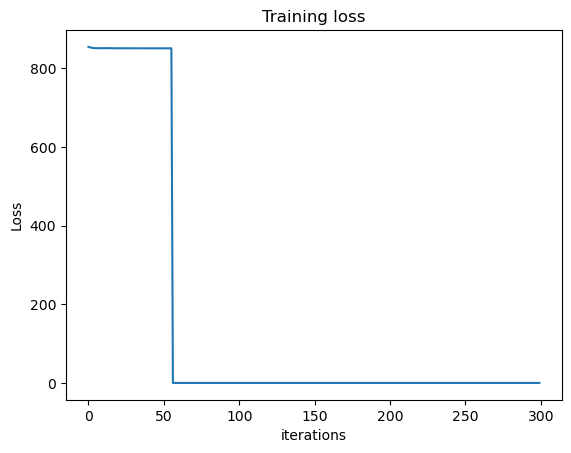

/tmp/ipykernel_5299/728929343.py:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)
/tmp/ipykernel_5299/3968403812.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


Epoch  0 , loss= 4.169581890106201
Epoch  10 , loss= 1.1729607582092285
Epoch  20 , loss= 0.7255112528800964
Epoch  30 , loss= 0.6846185326576233
Epoch  40 , loss= 0.6401336789131165
Epoch  50 , loss= 0.6192326545715332
Epoch  60 , loss= 0.6138734221458435
Epoch  70 , loss= 0.6110759377479553
Epoch  80 , loss= 0.6090628504753113
Epoch  90 , loss= 0.6077613830566406
Epoch  100 , loss= 0.6069461703300476
Epoch  110 , loss= 0.6064282059669495
Epoch  120 , loss= 0.6060901880264282
Epoch  130 , loss= 0.6058669686317444
Epoch  140 , loss= 0.605720043182373
Epoch  150 , loss= 0.6056239604949951
Epoch  160 , loss= 0.6055611968040466
Epoch  170 , loss= 0.6055203080177307
Epoch  180 , loss= 0.6054937839508057
Epoch  190 , loss= 0.6054768562316895


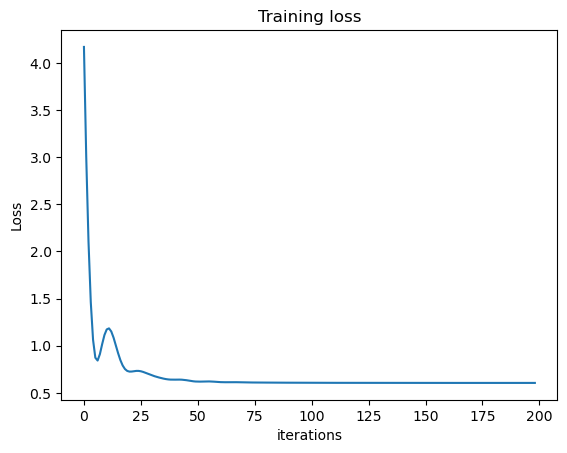

In [23]:
m = 'CanESM5-1'
lambda_ridge = 200.0
lambda_robust = 200.0
mu_ = 300

beta_robust_tmp, y_pred_robust_tmp, y_test_robust_tmp, weights_robust_tmp, rmse_training_robust_tmp \
= leave_one_out(m,x_predictor,y_forced_response,\
                variance_processed_ssp585,\
                lon_size,lat_size,\
                lambda_robust,method='robust',mu_=mu_,\
                nbEpochs=300,verbose=True)

beta_ridge_tmp, y_pred_ridge_tmp, y_test_ridge_tmp, weights_ridge_tmp, rmse_training_ridge_tmp \
= leave_one_out(m,x_predictor,y_forced_response,variance_processed_ssp585,\
                lon_size,lat_size,\
                lambda_ridge,method='ridge',mu_=mu_,
                nbEpochs=300,verbose=True)

In [24]:
rmse_robust_test = torch.zeros(len(x_predictor[m].keys()))
for idx_r, r in enumerate(x_predictor[m].keys()):
    rmse_robust_test[idx_r] = np.mean((y_pred_robust_tmp[r] - y_test_robust_tmp[r])**2/variance_processed_ssp585[m].detach().numpy())

rmse_ridge_test = torch.zeros(len(x_predictor[m].keys()))
for idx_r, r in enumerate(x_predictor[m].keys()):
    
    rmse_ridge_test[idx_r] = np.mean((y_pred_ridge_tmp[r] - y_test_ridge_tmp[r])**2/variance_processed_ssp585[m].detach().numpy())
    
print(torch.mean(rmse_ridge_test))
print(torch.mean(rmse_robust_test))

tensor(0.8692)
tensor(0.9380)


In [25]:
idx_tmp = torch.argmin(variance_processed_ssp585[m]).item()

In [26]:
def leave_one_out_procedure(x,y,vars,lon_size,lat_size,lambda_,method='robust',mu_=1.0,nbEpochs=500,verbose=True):

    beta = {}
    y_pred = {}
    y_test = {}
    rmse_mean = {}
    rmse_q95 = {}
    rmse_worst = {}
    
    weights = {m: 0.0 for idx_m, m in enumerate(x.keys())}
    training_loss = {m: np.zeros(len(x.keys())) for idx_m, m in enumerate(x.keys())}
    
    for idx_m, m in enumerate(x.keys()):
        
        beta[m], y_pred[m], y_test[m], weights_tmp, training_loss[m] = leave_one_out(m,x,y,vars,lon_size,lat_size,lambda_,method,mu_,nbEpochs,verbose)

        rmse_mean[m] = 0
        err_tmp = np.zeros(len(x[m].keys()))
        
        for idx_i, i in enumerate(x[m].keys()):
            rmse_mean[m] += np.mean(((y_test[m][i] - y_pred[m][i])**2/vars[m]).detach().numpy())
            err_tmp[idx_i] = np.mean(((y_test[m][i] - y_pred[m][i])**2/vars[m]).detach().numpy())
            
        rmse_mean[m] = rmse_mean[m]/len(x[m].keys())
        rmse_q95[m] = np.quantile(err_tmp,0.95)
        rmse_worst[m] = np.max(err_tmp)
            
        # compute the weight when a single model is out 
        if method == 'robust':    
            for m_tmp in list(x.keys()):
                if m_tmp != m:
                    weights[m_tmp] += (1/(len(x.keys())))* weights_tmp[m_tmp]

        # print the rmse
        print('RMSE (mean) on model ', m, ' : ', rmse_mean[m])
        print('RMSE (95%) on model ', m, ' : ', rmse_q95[m])
        print('RMSE (worst) on model ', m, ' : ', rmse_worst[m])

    
    ################# plot the weights #################
    fig, ax = plt.subplots()
    models = list(x.keys()) 
    weights_plot = list(weights.values()) 
    ax.bar(models, weights_plot,label='Model weights')
    ax.set_ylabel(r'weights $\gamma$')
    ax.set_title('cmip6 models')
    ax.legend()
    ax.set_xticklabels(models, rotation=-90)
    plt.tight_layout()
    plt.savefig("results/weights_"+method+"_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()

    ################# plot the rmse #################
    fig, ax = plt.subplots()
    models = list(x.keys()) 
    rmse_plot = list(rmse_mean.values()) 
    ax.bar(models, rmse_plot,label='rmse')
    ax.set_ylabel(r'LOO')
    ax.set_title('LOO rmse')
    ax.legend()
    ax.set_xticklabels(models, rotation=-90)
    plt.tight_layout()
    plt.savefig("results/rmse_"+method+"_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    

    return beta, rmse_mean, rmse_q95, rmse_worst, weights, training_loss

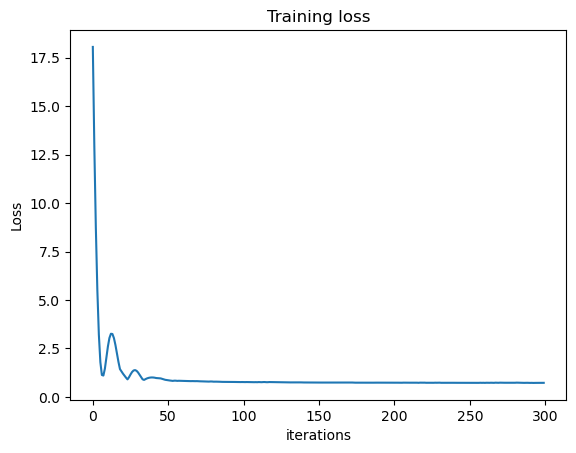

/tmp/ipykernel_5299/728929343.py:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)
/tmp/ipykernel_5299/3968403812.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


RMSE (mean) on model  CanESM5-1  :  0.830085062187965
RMSE (95%) on model  CanESM5-1  :  1.7607829191942337
RMSE (worst) on model  CanESM5-1  :  1.8292717178034492


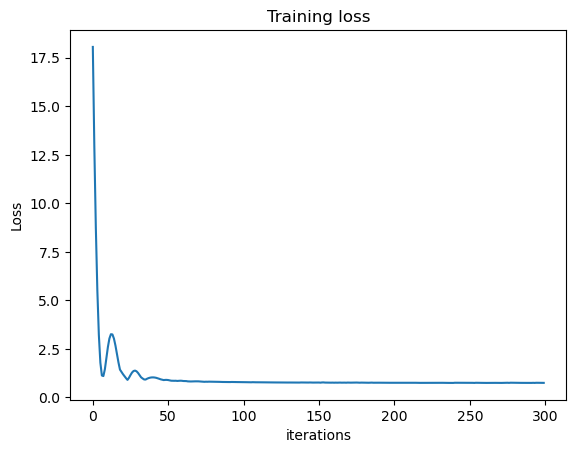

RMSE (mean) on model  CNRM-ESM2-1  :  0.544753026598888
RMSE (95%) on model  CNRM-ESM2-1  :  0.7190416628688359
RMSE (worst) on model  CNRM-ESM2-1  :  0.7353708987499813


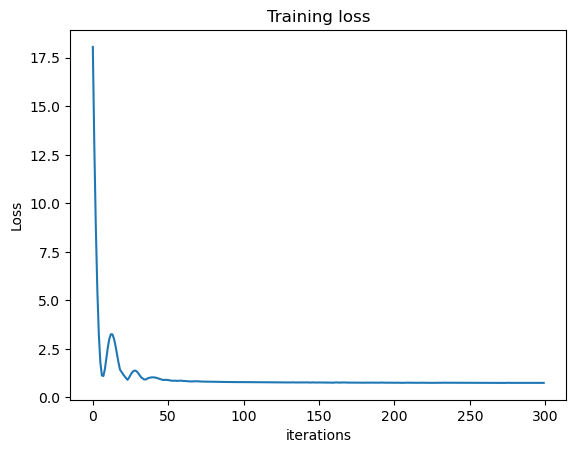

RMSE (mean) on model  GISS-E2-2-G  :  0.4623660233182888
RMSE (95%) on model  GISS-E2-2-G  :  0.5906491416749029
RMSE (worst) on model  GISS-E2-2-G  :  0.6006444691705597


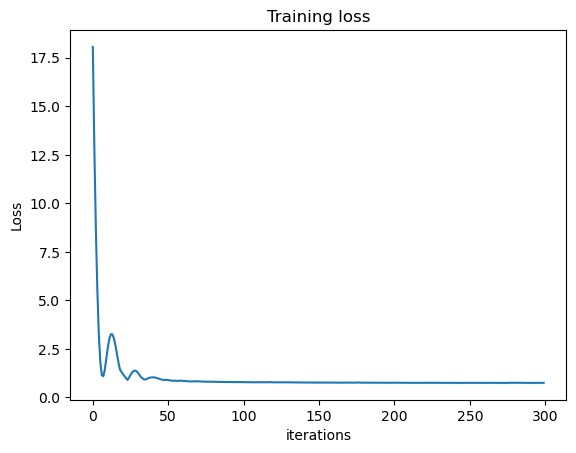

RMSE (mean) on model  CNRM-CM6-1  :  0.6313444099078415
RMSE (95%) on model  CNRM-CM6-1  :  0.9530047962062527
RMSE (worst) on model  CNRM-CM6-1  :  1.0408172782519316


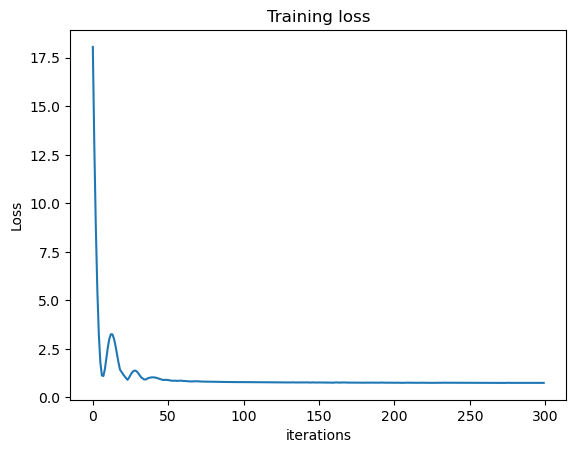

RMSE (mean) on model  MIROC-ES2L  :  0.4764262426300757
RMSE (95%) on model  MIROC-ES2L  :  0.703837884207483
RMSE (worst) on model  MIROC-ES2L  :  0.7825819165665502


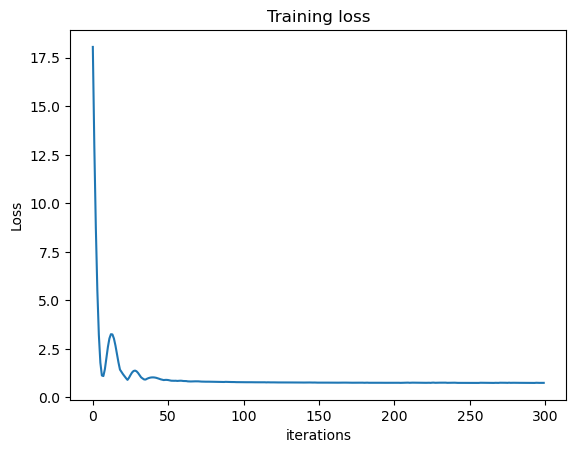

RMSE (mean) on model  EC-Earth3  :  0.603934768130957
RMSE (95%) on model  EC-Earth3  :  1.0362294066484672
RMSE (worst) on model  EC-Earth3  :  1.107857044437294


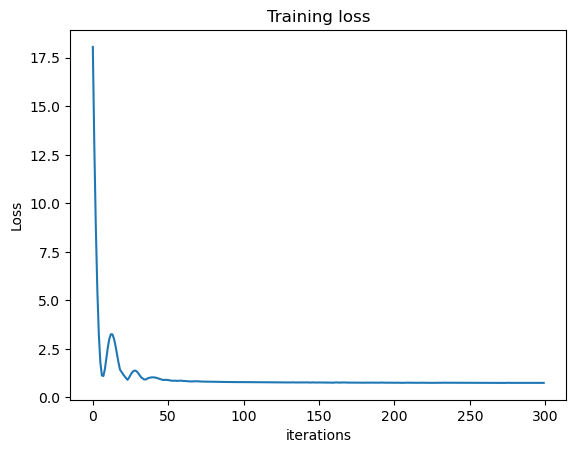

RMSE (mean) on model  GISS-E2-1-H  :  0.5512137494726461
RMSE (95%) on model  GISS-E2-1-H  :  0.6620361310044351
RMSE (worst) on model  GISS-E2-1-H  :  0.6764068131089785


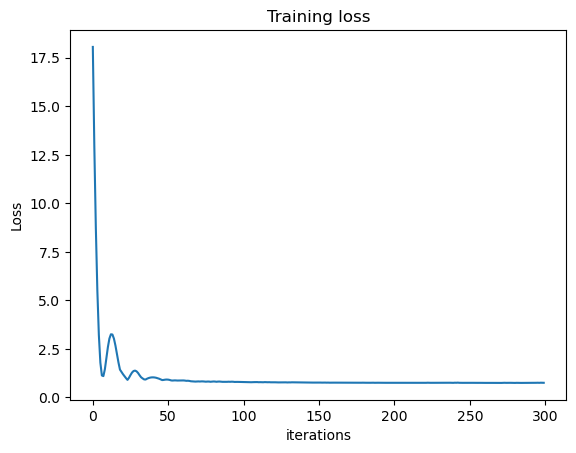

RMSE (mean) on model  EC-Earth3-Veg  :  0.6177237612089039
RMSE (95%) on model  EC-Earth3-Veg  :  0.8167715126209059
RMSE (worst) on model  EC-Earth3-Veg  :  0.8428719081511975


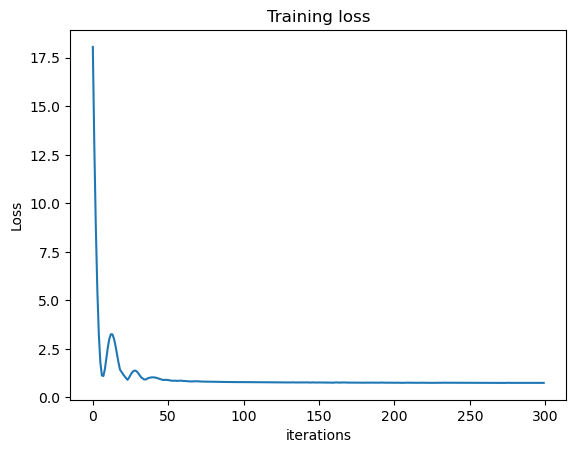

RMSE (mean) on model  MIROC6  :  0.43921213749601
RMSE (95%) on model  MIROC6  :  0.6488739295257594
RMSE (worst) on model  MIROC6  :  0.7023135373051469


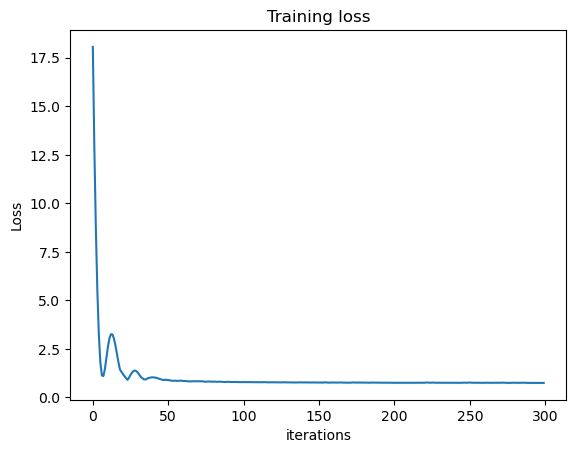

RMSE (mean) on model  CESM2  :  0.6526136197612022
RMSE (95%) on model  CESM2  :  0.937531471748399
RMSE (worst) on model  CESM2  :  0.985236660766094


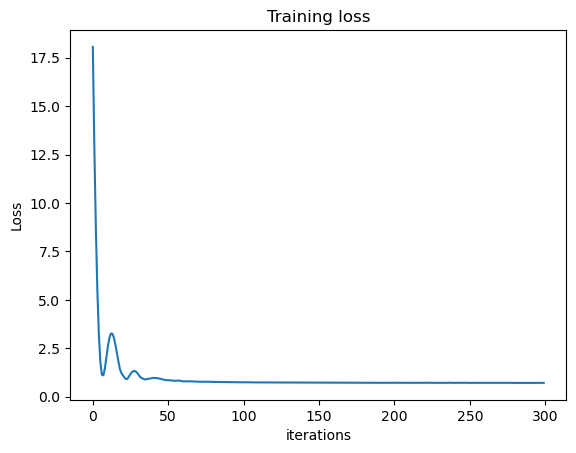

RMSE (mean) on model  GISS-E2-1-G  :  0.8182302822844977
RMSE (95%) on model  GISS-E2-1-G  :  1.2939532582921809
RMSE (worst) on model  GISS-E2-1-G  :  1.4174215044126164


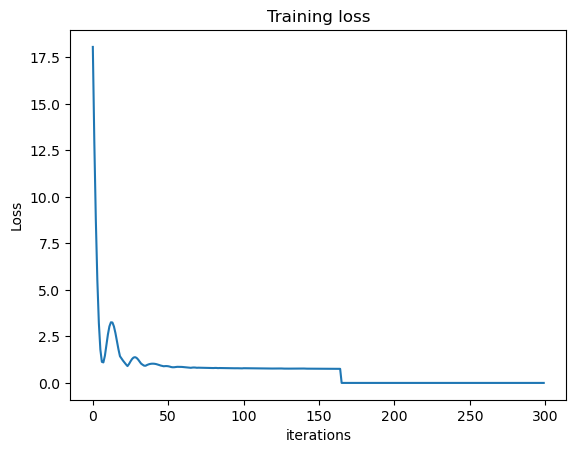

RMSE (mean) on model  MRI-ESM2-0  :  0.7032668917437562
RMSE (95%) on model  MRI-ESM2-0  :  1.2740287116094953
RMSE (worst) on model  MRI-ESM2-0  :  1.4118148954599972


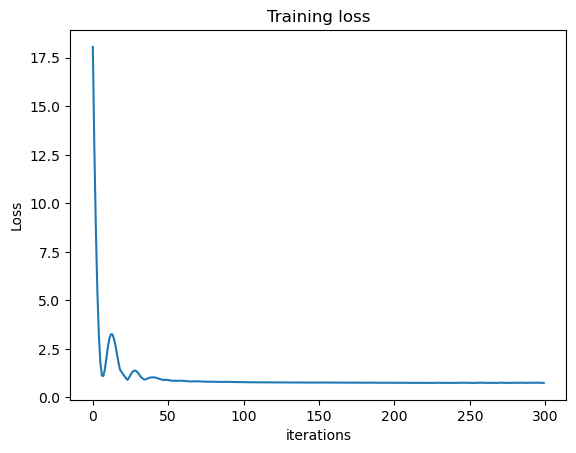

RMSE (mean) on model  ACCESS-ESM1-5  :  0.6218561393177973
RMSE (95%) on model  ACCESS-ESM1-5  :  1.08329628719401
RMSE (worst) on model  ACCESS-ESM1-5  :  1.3478465417160006


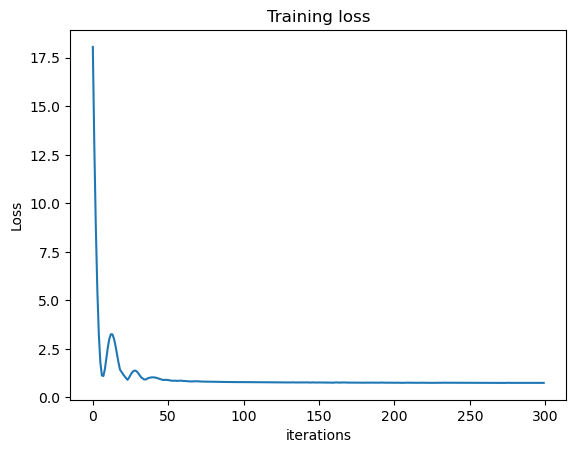

RMSE (mean) on model  IPSL-CM6A-LR  :  0.4934274607556394
RMSE (95%) on model  IPSL-CM6A-LR  :  0.62862359703584
RMSE (worst) on model  IPSL-CM6A-LR  :  0.645007954632265


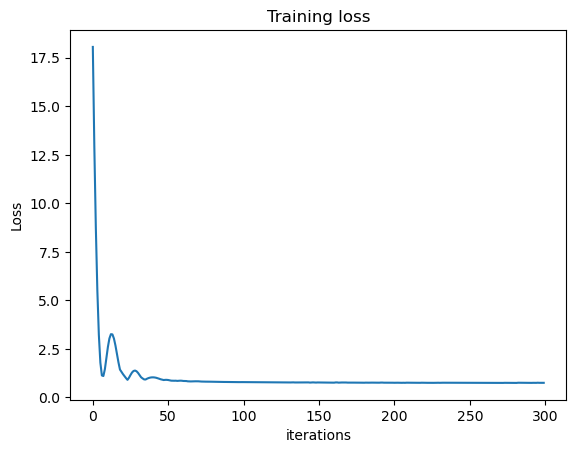

RMSE (mean) on model  CanESM5  :  0.5909392623739201
RMSE (95%) on model  CanESM5  :  1.2492553673631577
RMSE (worst) on model  CanESM5  :  1.4813238640491049


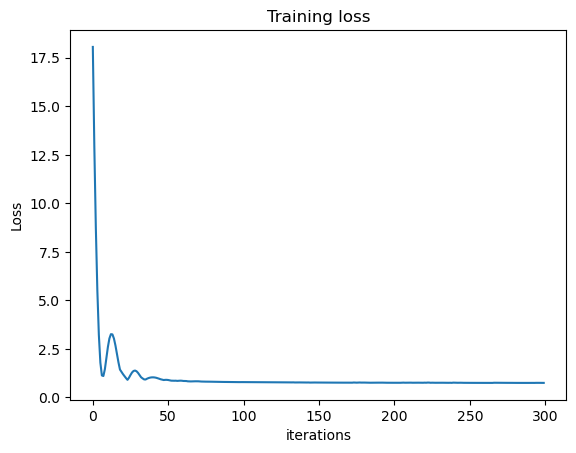

RMSE (mean) on model  ACCESS-CM2  :  0.6003649808968629
RMSE (95%) on model  ACCESS-CM2  :  1.4040107316536534
RMSE (worst) on model  ACCESS-CM2  :  1.4767277638996958


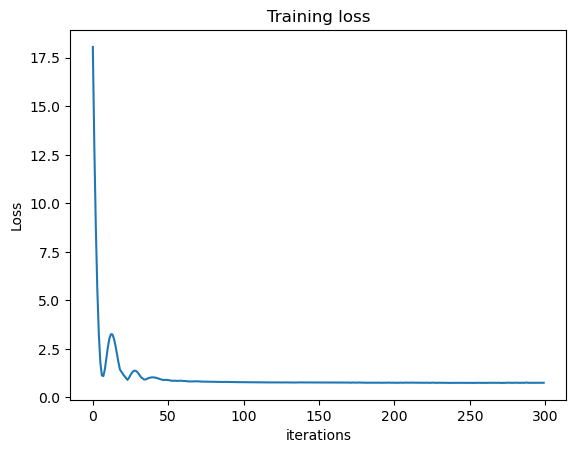

RMSE (mean) on model  MPI-ESM1-2-LR  :  0.5187297024966294
RMSE (95%) on model  MPI-ESM1-2-LR  :  0.7750339791135886
RMSE (worst) on model  MPI-ESM1-2-LR  :  0.8822246687722791


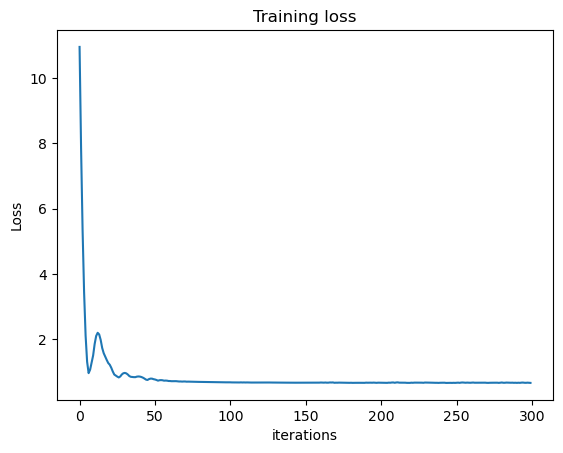

RMSE (mean) on model  UKESM1-0-LL  :  1.8787596708026206
RMSE (95%) on model  UKESM1-0-LL  :  2.303108146906615
RMSE (worst) on model  UKESM1-0-LL  :  2.317018528732661


/tmp/ipykernel_5299/3123796454.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


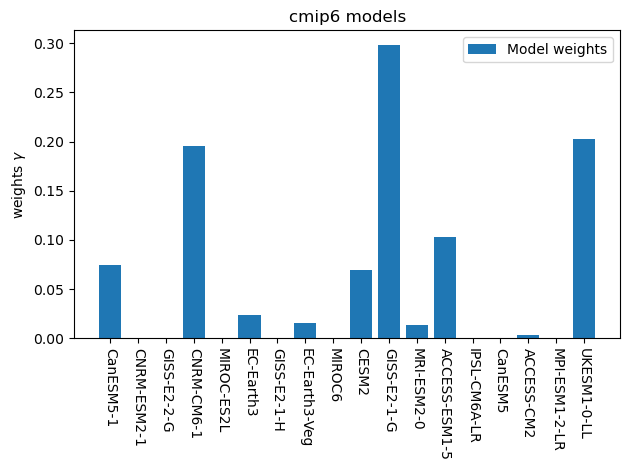

/tmp/ipykernel_5299/3123796454.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


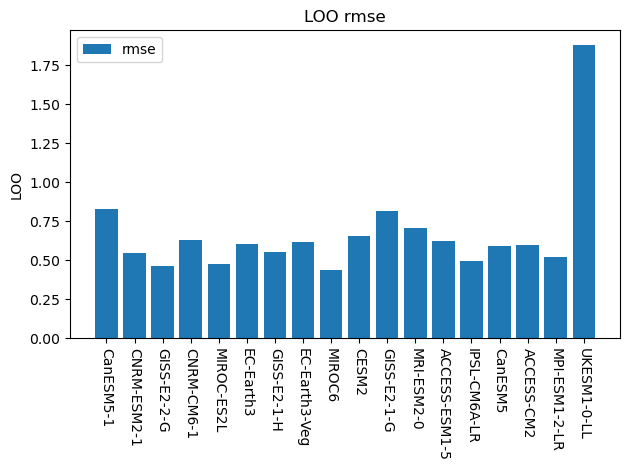

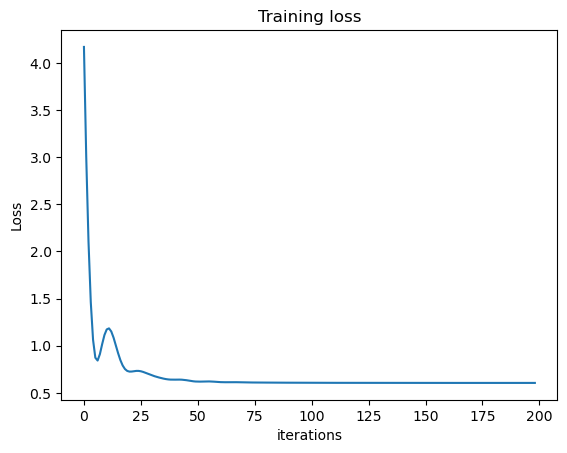

RMSE (mean) on model  CanESM5-1  :  0.8691710881349428
RMSE (95%) on model  CanESM5-1  :  1.8927269506385636
RMSE (worst) on model  CanESM5-1  :  2.0643841840831016


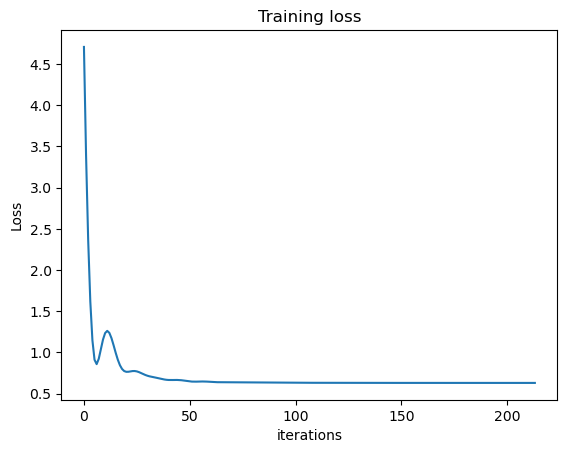

RMSE (mean) on model  CNRM-ESM2-1  :  0.4110400017245504
RMSE (95%) on model  CNRM-ESM2-1  :  0.5118515071959554
RMSE (worst) on model  CNRM-ESM2-1  :  0.5212297581988024


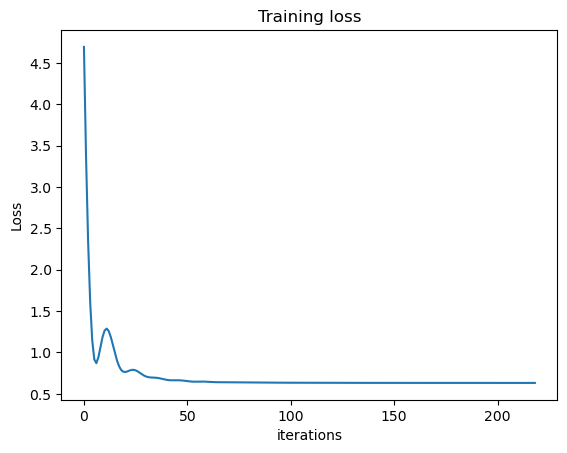

RMSE (mean) on model  GISS-E2-2-G  :  0.3641342569411058
RMSE (95%) on model  GISS-E2-2-G  :  0.44244825999764614
RMSE (worst) on model  GISS-E2-2-G  :  0.4461701140942919


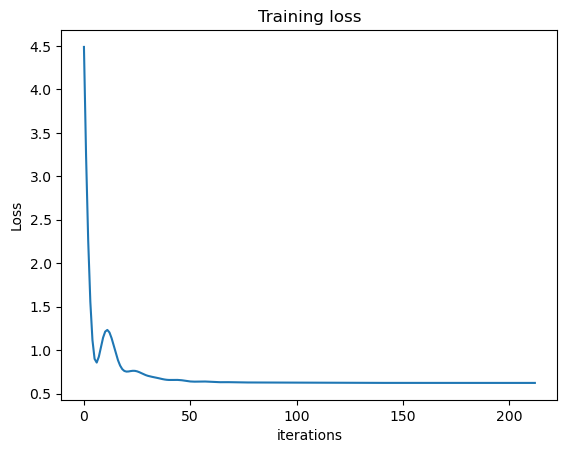

RMSE (mean) on model  CNRM-CM6-1  :  0.5515278106385592
RMSE (95%) on model  CNRM-CM6-1  :  0.7202441857132771
RMSE (worst) on model  CNRM-CM6-1  :  0.7555821740139129


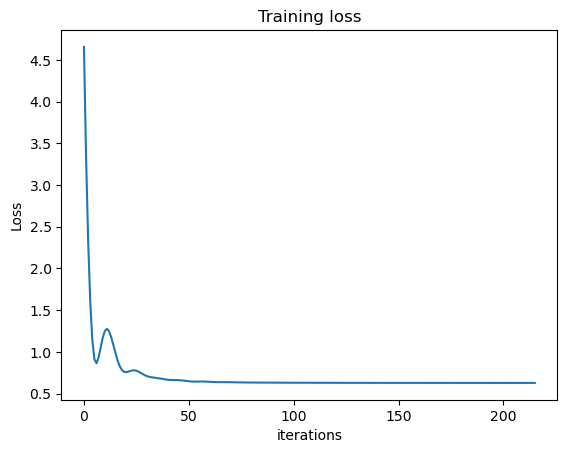

RMSE (mean) on model  MIROC-ES2L  :  0.41031528307252063
RMSE (95%) on model  MIROC-ES2L  :  0.6144052209424797
RMSE (worst) on model  MIROC-ES2L  :  0.6267017169886542


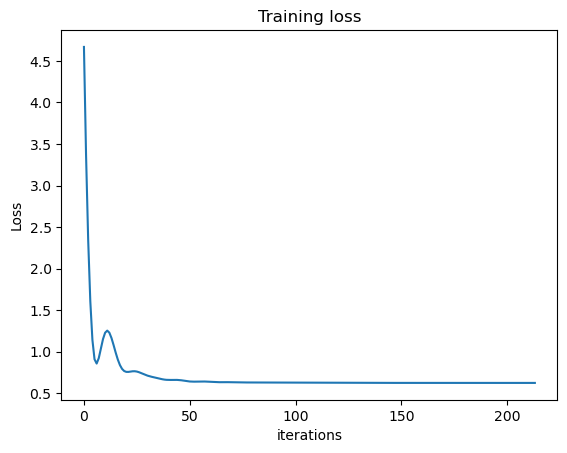

RMSE (mean) on model  EC-Earth3  :  0.4778591552208594
RMSE (95%) on model  EC-Earth3  :  0.790779799194084
RMSE (worst) on model  EC-Earth3  :  0.837304258197984


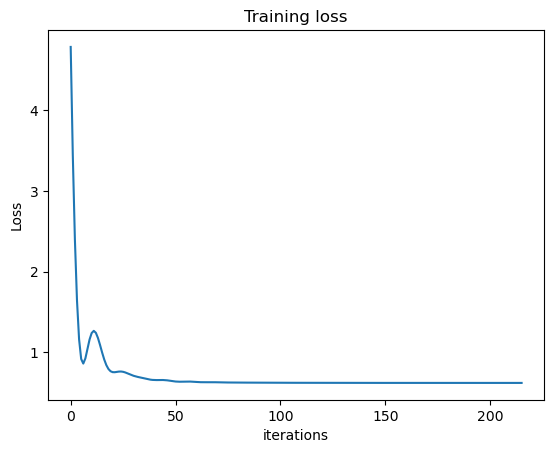

RMSE (mean) on model  GISS-E2-1-H  :  0.5686804222999302
RMSE (95%) on model  GISS-E2-1-H  :  0.6800576685474441
RMSE (worst) on model  GISS-E2-1-H  :  0.6909442024400463


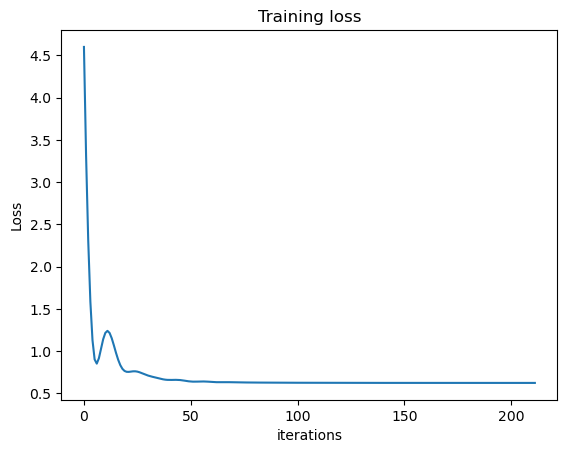

RMSE (mean) on model  EC-Earth3-Veg  :  0.5024784193295291
RMSE (95%) on model  EC-Earth3-Veg  :  0.642970405136554
RMSE (worst) on model  EC-Earth3-Veg  :  0.6490388256562462


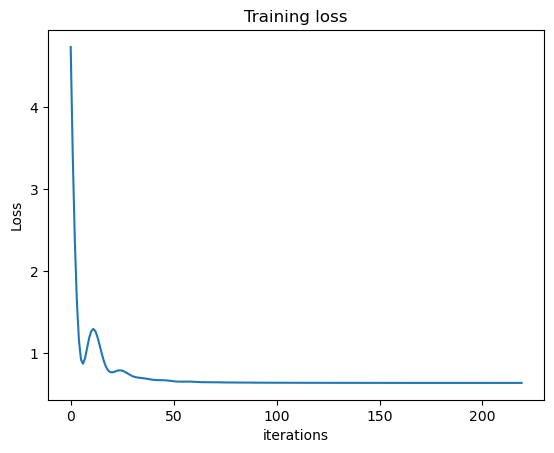

RMSE (mean) on model  MIROC6  :  0.32549692268808544
RMSE (95%) on model  MIROC6  :  0.5138759736588595
RMSE (worst) on model  MIROC6  :  0.5693320085746629


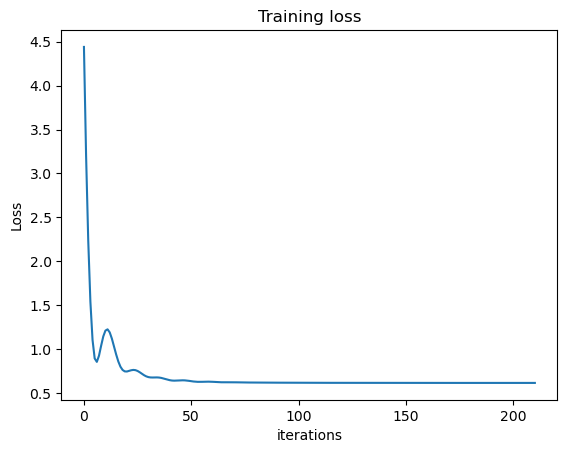

RMSE (mean) on model  CESM2  :  0.6661127111682272
RMSE (95%) on model  CESM2  :  0.8111533911238077
RMSE (worst) on model  CESM2  :  0.8374237953873629


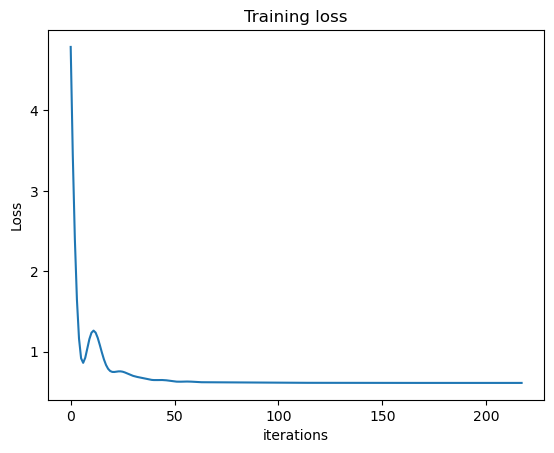

RMSE (mean) on model  GISS-E2-1-G  :  0.7445055112845598
RMSE (95%) on model  GISS-E2-1-G  :  1.2252160357524904
RMSE (worst) on model  GISS-E2-1-G  :  1.347884829951209


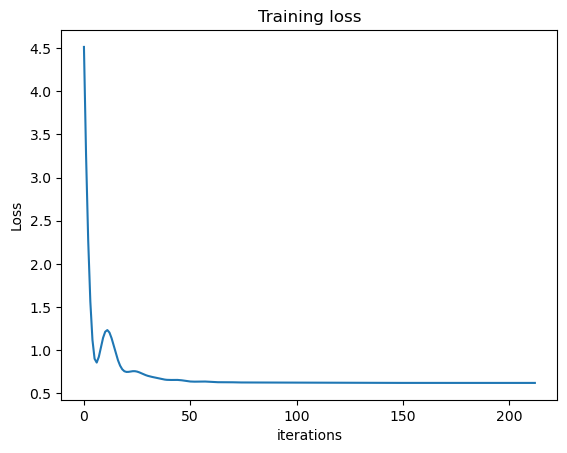

RMSE (mean) on model  MRI-ESM2-0  :  0.5809222786220744
RMSE (95%) on model  MRI-ESM2-0  :  1.122347388314433
RMSE (worst) on model  MRI-ESM2-0  :  1.2933504195192997


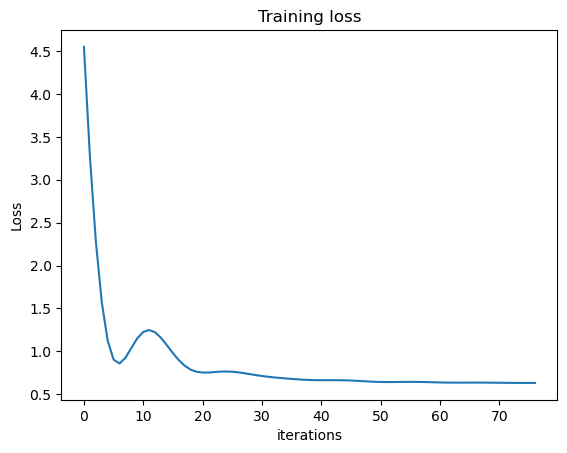

RMSE (mean) on model  ACCESS-ESM1-5  :  0.48265787590155085
RMSE (95%) on model  ACCESS-ESM1-5  :  0.7670153293915932
RMSE (worst) on model  ACCESS-ESM1-5  :  0.8938907230490106


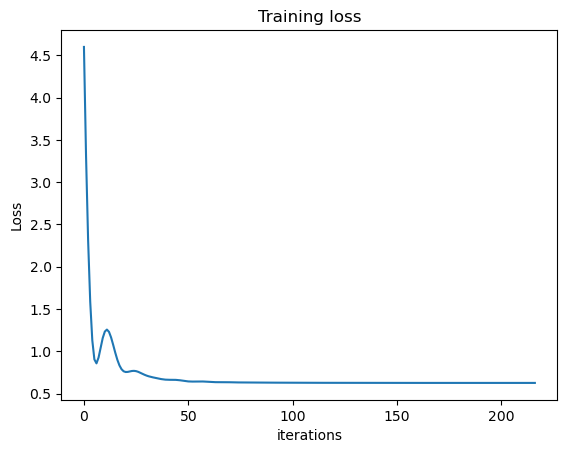

RMSE (mean) on model  IPSL-CM6A-LR  :  0.4270203595728295
RMSE (95%) on model  IPSL-CM6A-LR  :  0.598031057017927
RMSE (worst) on model  IPSL-CM6A-LR  :  0.6137964673097547


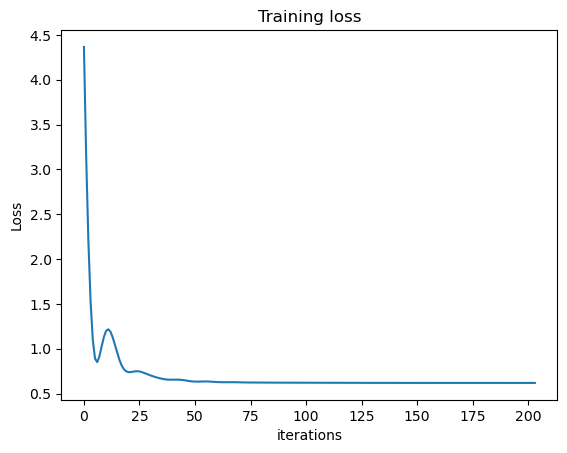

RMSE (mean) on model  CanESM5  :  0.5887240787606143
RMSE (95%) on model  CanESM5  :  1.0664929898071562
RMSE (worst) on model  CanESM5  :  1.2705643107480298


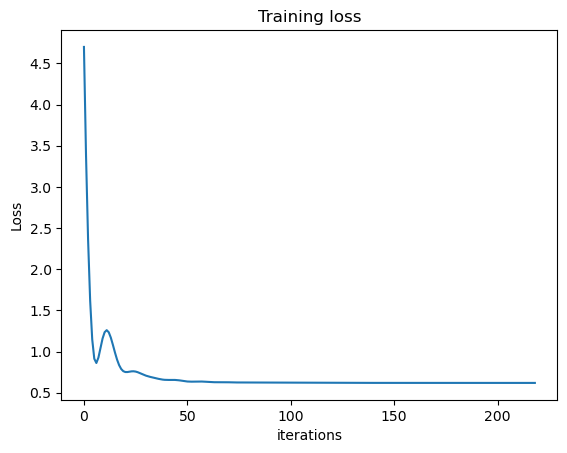

RMSE (mean) on model  ACCESS-CM2  :  0.5805467351569121
RMSE (95%) on model  ACCESS-CM2  :  1.4003727729686677
RMSE (worst) on model  ACCESS-CM2  :  1.4444626715848659


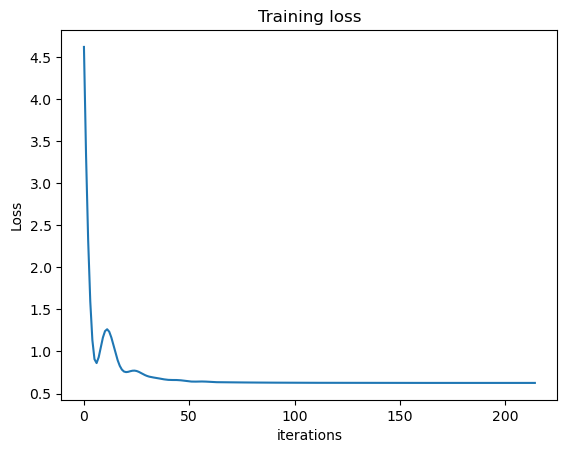

RMSE (mean) on model  MPI-ESM1-2-LR  :  0.4493527115087309
RMSE (95%) on model  MPI-ESM1-2-LR  :  0.67867351310998
RMSE (worst) on model  MPI-ESM1-2-LR  :  0.7337353739644258


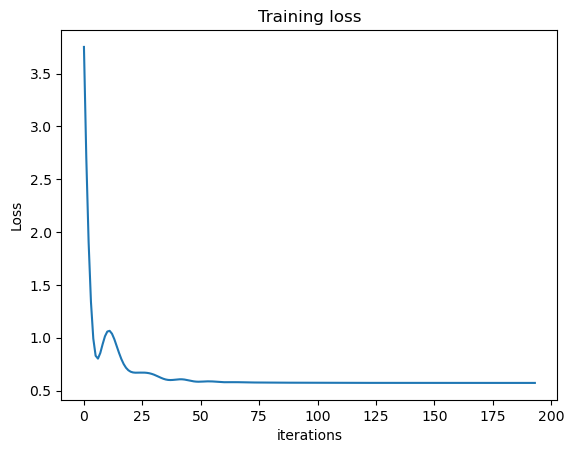

RMSE (mean) on model  UKESM1-0-LL  :  2.001009028652166
RMSE (95%) on model  UKESM1-0-LL  :  2.415471349261004
RMSE (worst) on model  UKESM1-0-LL  :  2.469453480054024


/tmp/ipykernel_5299/3123796454.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


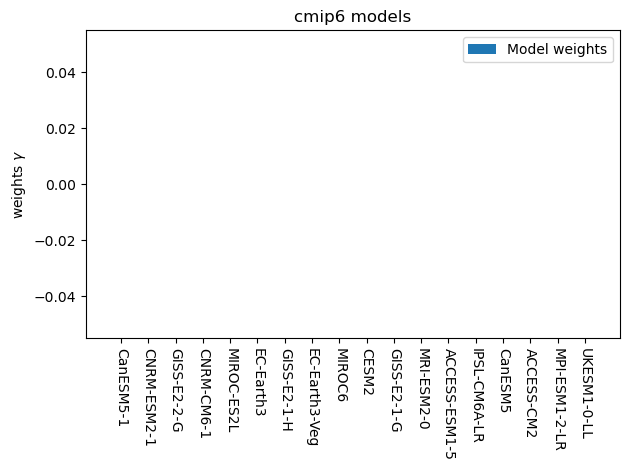

/tmp/ipykernel_5299/3123796454.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


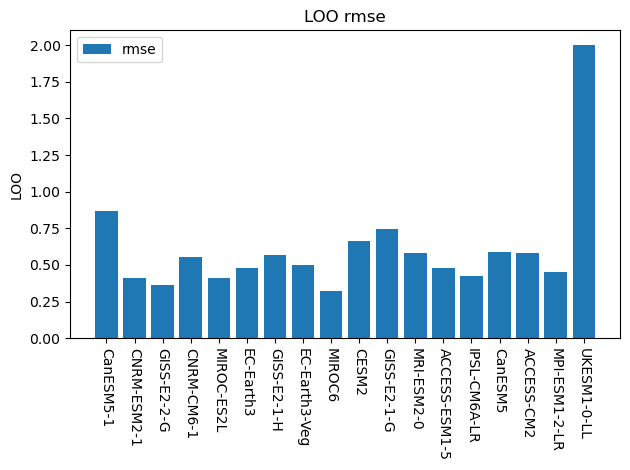

In [27]:
mu_ = 0.001
lambda_robust = 200.0
lambda_ridge = 200.0
beta_robust, rmse_robust_mean,rmse_robust_q95,rmse_robust_worst, weights_robust, rmse_training_robust = leave_one_out_procedure(x_predictor,y_forced_response,variance_processed_ssp585,\
                                                grid_lon_size,grid_lat_size,\
                                                lambda_=lambda_robust,method='robust',mu_=mu_,\
                                                nbEpochs=300,verbose=False)

beta_ridge, rmse_ridge_mean, rmse_ridge_q95, rmse_ridge_worst, weights_ridge, rmse_training_ridge = leave_one_out_procedure(x_predictor,y_forced_response,variance_processed_ssp585,\
                                                grid_lon_size,grid_lat_size,\
                                                lambda_=lambda_ridge,method='ridge',mu_=mu_,\
                                                nbEpochs=300,verbose=False)

In [28]:
################## Robust regression #########################
# compute the robust loo 
rmse_robust_tmp =  np.array(list(rmse_robust_mean.values()))

# worst loo
worst_loo_robust = np.max(rmse_robust_tmp)
mean_loo_robust = np.mean(rmse_robust_tmp)


# quantile 95, 90, 75
q_loo_95_robust = np.quantile(rmse_robust_tmp, 0.95)
q_loo_90_robust = np.quantile(rmse_robust_tmp, 0.90)
q_loo_75_robust = np.quantile(rmse_robust_tmp, 0.75)
q_loo_50_robust = np.quantile(rmse_robust_tmp, 0.5)

################### Ridge regresssion ########################
# compute the ridge loo
rmse_ridge_tmp =  np.array(list(rmse_ridge_mean.values()))

# worst loo Ridge
worst_loo_ridge = np.max(rmse_ridge_tmp)
mean_loo_ridge = np.mean(rmse_ridge_tmp)


# quantile 95, 90, 75
q_loo_95_ridge = np.quantile(rmse_ridge_tmp, 0.95)
q_loo_90_ridge = np.quantile(rmse_ridge_tmp, 0.90)
q_loo_75_ridge = np.quantile(rmse_ridge_tmp, 0.75)
q_loo_50_ridge = np.quantile(rmse_ridge_tmp, 0.5)



print("======= Statistics ========")
print("\n")
print("          Robust Ridge")
print("0.95:     {:.3f}  {:.3f}".format(q_loo_95_robust,q_loo_95_ridge))
print("0.90:     {:.3f}  {:.3f}".format(q_loo_90_robust,q_loo_90_ridge))
print("0.75:     {:.3f}  {:.3f}".format(q_loo_75_robust,q_loo_75_ridge))
print("Median:   {:.3f}  {:.3f}".format(q_loo_50_robust,q_loo_50_ridge))
print("Mean:     {:.3f}  {:.3f}".format(mean_loo_robust,mean_loo_ridge))
print("Worst:    {:.3f}  {:.3f}".format(worst_loo_robust,worst_loo_ridge))

======= Statistics ========


          Robust Ridge
0.95:     0.987  1.039
0.90:     0.822  0.782
0.75:     0.647  0.587
Median:   0.602  0.527
Mean:     0.669  0.611
Worst:    1.879  2.001


In [29]:
# ======= Statistics ========


#           Robust Ridge
# 0.95:     1.712  1.835
# 0.90:     1.430  1.583
# 0.75:     0.919  1.190
# Median:   0.686  0.575
# Mean:     0.861  0.898
# Worst:    1.994  2.086

In [30]:
beta_robust

{'CanESM5-1': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0001, 0.0001, 0.0002],
        dtype=torch.float64, requires_grad=True),
 'CNRM-ESM2-1': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0001, 0.0001, 0.0001],
        dtype=torch.float64, requires_grad=True),
 'GISS-E2-2-G': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0001, 0.0001, 0.0001],
        dtype=torch.float64, requires_grad=True),
 'CNRM-CM6-1': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0001, 0.0001, 0.0002],
        dtype=torch.float64, requires_grad=True),
 'MIROC-ES2L': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0001, 0.0001, 0.0001],
        dtype=torch.float64, requires_grad=True),
 'EC-Earth3': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0001, 0.0001, 0.0002],
        dtype=torch.float64, requires_grad=True),
 'GISS-E2-1-H': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0001, 0.0001, 0.0001],
        dtype=torch.float64, requires_grad=True),
 'EC-Earth3-Veg': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0001, 0.0001, 0.0001],
        dtype=torch.fl

/tmp/ipykernel_5299/2756190840.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


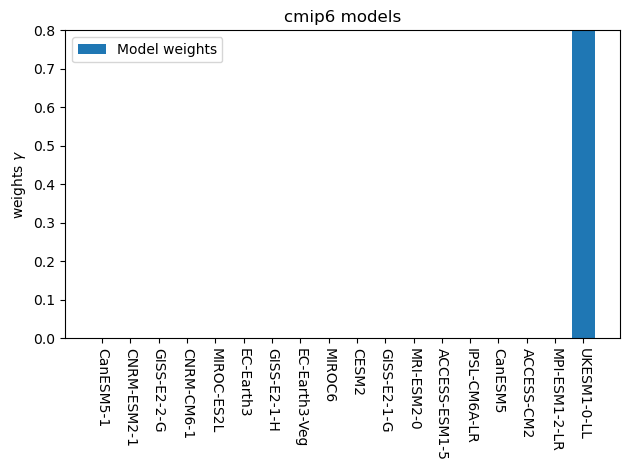

In [31]:
M = len(list(dic_reduced_ssp585.keys()))
gamma = torch.zeros(M)
res = torch.zeros(M,33)

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        res[idx_m,:] += (y_train[m][i] - torch.matmul(x_train[m][i],beta_robust[m]))**2/variance_processed_ssp585[m]
        
    res[idx_m,:] = res[idx_m,:]/len(dic_reduced_ssp585[m].keys())

    gamma[idx_m] = (1/mu_)*torch.nanmean(res[idx_m,:],axis=0)


gamma = torch.nn.functional.softmax(gamma,dim=0)


# plot the model contributions
fig, ax = plt.subplots()
models = list(dic_reduced_ssp585.keys())
weights = list(gamma.detach().numpy())

ax.bar(models, weights,label='Model weights')
ax.set_ylabel(r'weights $\gamma$')
ax.set_ylim(0.0,0.8)
ax.set_title('cmip6 models')
ax.legend()
ax.set_xticklabels(models, rotation=-90)
plt.tight_layout()
plt.show()

In [32]:
def cross_validation_loo(x,y,vars,lon_size,lat_size,lambda_range,method='robust',alpha_range=np.array([0.1,1.0,10.0]),nbEpochs=500,verbose=True):

    # create the pytorch tensor 
    beta = {}
    rmse = {}
    weights = {}
    y_pred = {}
    y_test = {}

    if method != 'robust':
        alpha_range_tmp = np.array([1.0])
    
    # for each pair (alpha, lambda) perform validation
    
    # for each lambda:
    for idx_lambda, lambda_ in enumerate(lambda_range):

        # for each alpha:
        for idx_alpha, alpha_ in enumerate(alpha_range):

            print("Cross validation: (" + str(alpha_)+", "+ str(lambda_)+ ")")

            beta_tmp, rmse_tmp, weights_tmp = leave_one_out_procedure(x,y,vars,\
                                                                      lon_size,lat_size,\
                                                                      lambda_,method,alpha_,\
                                                                      nbEpochs=2,verbose=False)

            beta[(alpha_,lambda_)] = beta_tmp
            rmse[(alpha_,lambda_)] = rmse_tmp
            weights[(alpha_,lambda_)] = weights_tmp

    return beta, rmse, weights

In [33]:
# alpha_range = np.linspace(0.5, 1000, num=10)
# lambda_range = np.linspace(0.01, 1000, num=20)


# alpha_range = np.array([0.5])
# lambda_range = np.array([500.0])

# with open('alpha_range.npy', 'wb') as f:
#     np.save(f, alpha_range)

# with open('lambda_range.npy', 'wb') as f:
#     np.save(f, lambda_range)

# beta_robust, rmse_robust, weights_robust = cross_validation_loo(x_predictor,y_forced_response,variance_processed_ssp585,\
#                                                                 grid_lon_size,grid_lat_size,\
#                                                                 lambda_range,'robust',alpha_range,\
#                                                                 nbEpochs=2,verbose=True)

In [34]:
# leave_one_out_procedure(x_predictor,y_forced_response,variance_processed_ssp585,\
#               grid_lon_size,grid_lat_size,\
#               alpha_,lambda_,\
#               nbEpochs=1000,verbose=False)

## All models vs Observations

In [35]:
# alpha_ = 0.5
# lambda_ = 50
# selected_models = list(dic_reduced_ssp585.keys())
# beta_robust = train_robust_model(x_train,y_train,variance_processed_ssp585,\
#                           grid_lat_size,grid_lat_size,\
#                           selected_models,alpha_,lambda_,nbEpochs=1000,verbose=True)

In [36]:
# ###### Compute residual ##########
# sst_tmp = sst[131:164,:,:].reshape((33,lon.shape[0]*lat.shape[0])).copy()
# sst_tmp[np.abs(sst_tmp)> 1e20] = float('nan')
# ytrue = np.nanmean(sst_tmp,axis=1)

# # for each model, compute the predicted values 
# sst_tmp_zeros = sst[131:164,:,:].reshape((33,lon.shape[0]*lat.shape[0])).copy()
# sst_tmp_zeros[np.abs(sst_tmp_zeros)> 1e20] = 0.0

In [37]:
# beta_robust_tmp = {i: beta_robust[i].detach().numpy() for i in beta_robust.keys()}
# beta_ridge_tmp = {i: beta_ridge[i].detach().numpy() for i in beta_ridge.keys()}

In [38]:
# beta_robust_tmp = np.nanmean(np.array(list(beta_robust_tmp.values())),axis=0)
# beta_ridge_tmp = np.nanmean(np.array(list(beta_ridge_tmp.values())),axis=0)

In [39]:
# ypred_robust = np.matmul(beta_robust_tmp,sst_tmp_zeros.T)
# ypred_ridge = np.matmul(beta_ridge_tmp,sst_tmp_zeros.T)

# rmse_real_robust = np.mean((ypred_robust - ytrue)**2)
# rmse_real_ridge = np.mean((ypred_ridge - ytrue)**2)
# print(rmse_real_robust)
# print(rmse_real_ridge)